In [311]:
from sdv.evaluation import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shap
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from numpy.linalg import norm

## Helper Functions

In [312]:
def heatmap_specs(dfs, names, plot_name=None, figsize=(10,15)):
    """
    Plots heatmaps of all spectral samples
    """
    fig, ax = plt.subplots(len(dfs), 1, figsize=figsize)
    
    for i, df in enumerate(dfs):
        sns.heatmap(df, ax=ax[i])
        ax[i].set_title(names[i])
    if plot_name:    
        plt.savefig(f"{plot_name}")
    plt.show()

def calculate_univariate_stats(df):
    """
    Function that calculates univariate stats of the dataframe
    """
    df_stats = df.describe().iloc[1:, :]
    df_stats.loc["skew", :] = df.skew()
    df_stats.loc["kurtosis", :] = df.kurt()
    return df_stats
    
def lineplot_specs(dfs, names, plot_name=None, figsize=(10,15)):
    """
    Plots all spectral samples in dataset
    """
    fig, ax = plt.subplots(len(dfs), 1, figsize=(10,15))

    for idx, df in enumerate(dfs):
        df.T.plot(legend=False, ax=ax[idx])
        ax[idx].set_title(names[idx])
    if plot_name:    
        plt.savefig(f"{plot_name}")
    plt.show()
    
def plot_sample(df, sample, plot_name=None):
    """
    Plots a line plot of a sample
    """
    plt.plot(df.T.index.astype(float), df.iloc[sample])
    if plot_name:    
        plt.savefig(f"{plot_name}")
    plt.show()

def plot_multiple_samples(dfs, samples, names, y_limit=(-0.9, 0.5), plot_name=None):
    """
    Plots multiple samples in individual subplots
    """
    fig, axes = plt.subplots(len(samples), len(dfs))

    for ax, name in zip(axes[0], names):
        ax.set_title(name)

    for idx1, df in enumerate(dfs):
        for idx2, sample in enumerate(samples):
            axes[idx2, idx1].plot(df.T.index.astype(float), df.iloc[sample])
            axes[idx2, idx1].set_ylim(y_limit)
    if plot_name:    
        plt.savefig(f"{plot_name}")
    
    plt.tight_layout()
    plt.show()

def create_nir_with_response(df):
    """
    Function that selects columns that have complete spectra, and adds 'DM' (dry matter) 
    as target. It then returns the dataframe with rows permuted.
    """
    nir = df.loc[:, '699':'1032'].copy()
    #nir = nir.copy()
    nir["DM"] = df["DM"].copy()
    return nir.reindex(np.random.RandomState(seed=1).permutation(nir.index))

# KL-divergence formula
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0)) 

# Cosine similarity
def cos_similarity(p,q):
    return 1 - distance.cosine(p, q)

def cosine_similarity(p, q):
    return np.dot(p, q)/(norm(p)*norm(q))


# Transforming columns
scaler = MinMaxScaler(feature_range=(-1, 1))
def transform_cols(df):
    df_2 = scaler.fit_transform(df)
    df_2 = pd.DataFrame(df_2)
    return df_2


In [313]:
# Setting up data
data = pd.read_csv("data/Mango_nir_vis.csv")
nir_response = create_nir_with_response(data)
nir = nir_response.drop("DM", axis=1)
nir_dm = nir_response["DM"]

In [314]:
# Setting up synthetic data
ctgan_nir_response = pd.read_csv("data/ctgan_nir_with_response.csv")
tvae_nir_response = pd.read_csv("data/tvae_nir_with_response.csv")

# Splitting synthetic datasets into spectras (features) and Dry Matter Content (resonse variable)
ctgan_nir = ctgan_nir_response.drop("DM", axis=1)
tvae_nir = tvae_nir_response.drop("DM", axis=1)

ctgan_dm = ctgan_nir_response["DM"]
tvae_dm = tvae_nir_response["DM"]

In [315]:
from scipy.stats import wasserstein_distance
wd_ctgan = []
for row in nir.index:
    wd_ctgan.append(wasserstein_distance(nir.iloc[row,:], ctgan_nir.iloc[row, :]))

In [316]:
from scipy.stats import wasserstein_distance
wd_tvae = []
for col in nir.columns:
    wd_tvae.append(wasserstein_distance(nir.loc[:,col], tvae_nir.loc[:, col]))

In [317]:
plt.plot(wd_tvae)

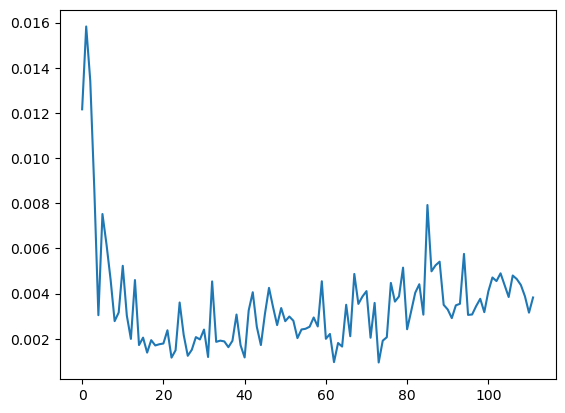

In [318]:
plt.show()

In [319]:
np.mean(wd_ctgan)

0.049449360610484105

### Savitzky-Golay Smoothing

In [320]:
from scipy import signal

# Smoothing CTGAN
ctgan_nir = signal.savgol_filter(ctgan_nir, window_length=21, polyorder=3)
ctgan_nir = pd.DataFrame(ctgan_nir, columns=nir.columns)

# Smoothing TVAE
tvae_nir = signal.savgol_filter(tvae_nir, window_length=21, polyorder=3)
tvae_nir = pd.DataFrame(tvae_nir, columns=nir.columns)

In [321]:
# Recombining response variable with smoothed specs
ctgan_nir_response.iloc[:, :-1] = ctgan_nir.copy()
tvae_nir_response.iloc[:, :-1] = tvae_nir.copy()


### Visual inspection

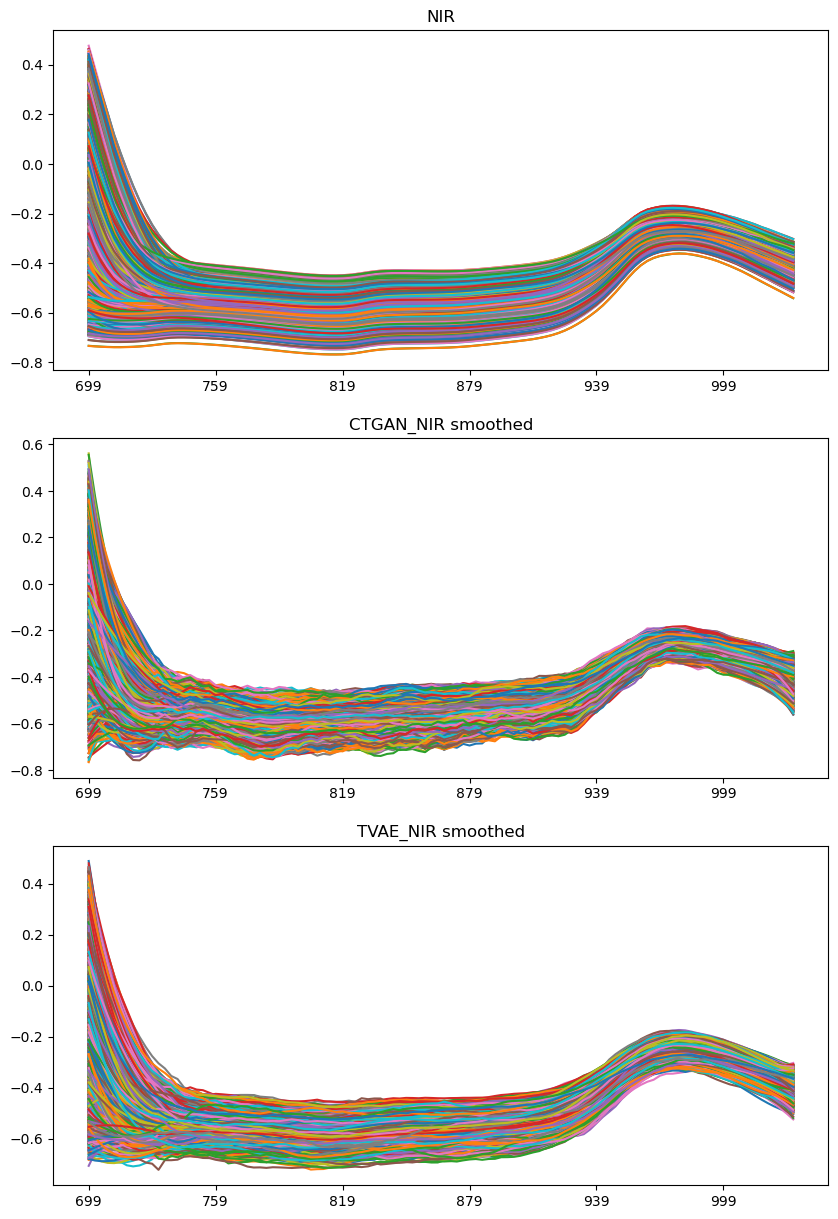

In [322]:
lineplot_specs([nir, ctgan_nir, tvae_nir], ["NIR", "CTGAN_NIR smoothed", "TVAE_NIR smoothed"])

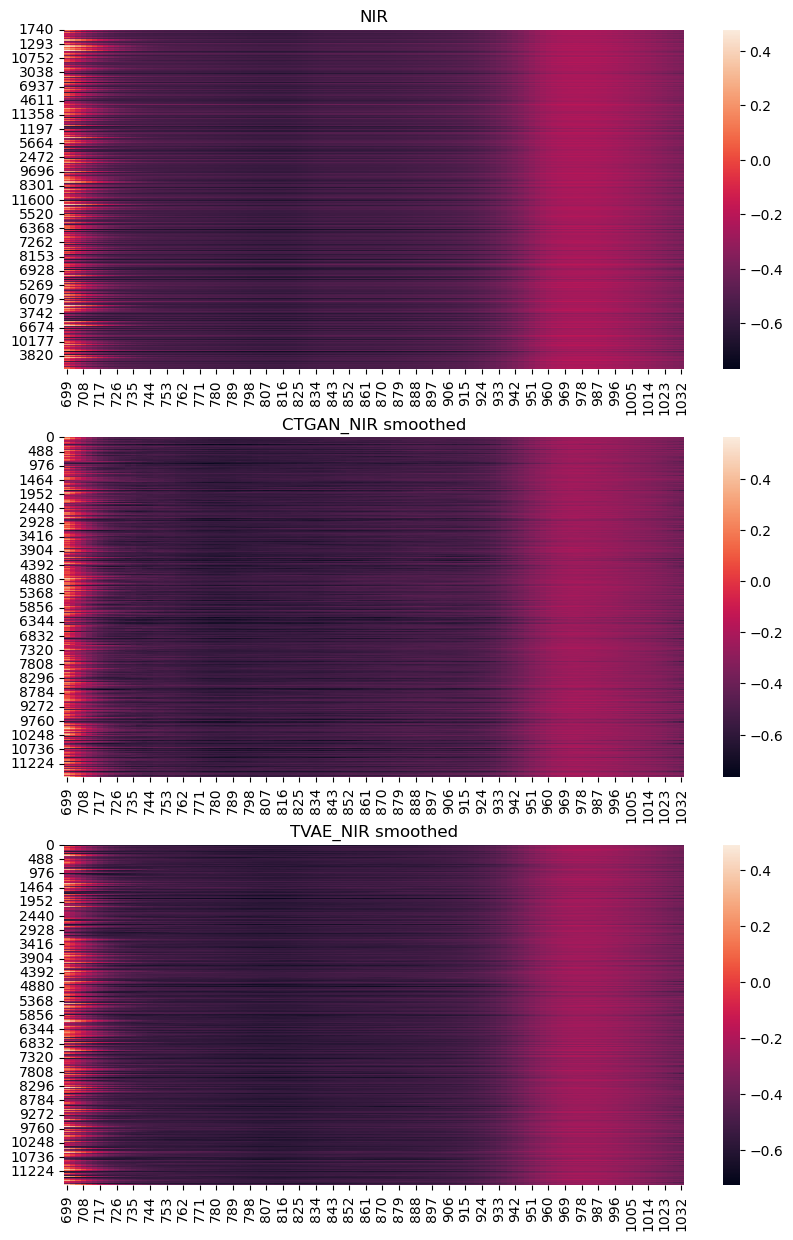

In [323]:
heatmap_specs([nir, ctgan_nir, tvae_nir], ["NIR", "CTGAN_NIR smoothed", "TVAE_NIR smoothed"])

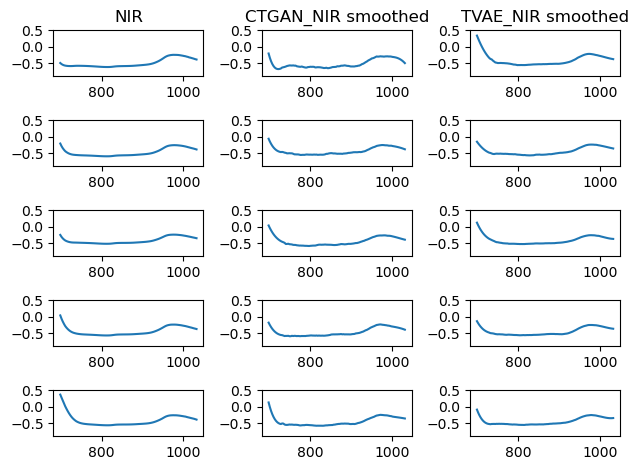

In [324]:
plot_multiple_samples([nir, ctgan_nir, tvae_nir], list(range(10, 51, 10)), ["NIR", "CTGAN_NIR smoothed", "TVAE_NIR smoothed"])

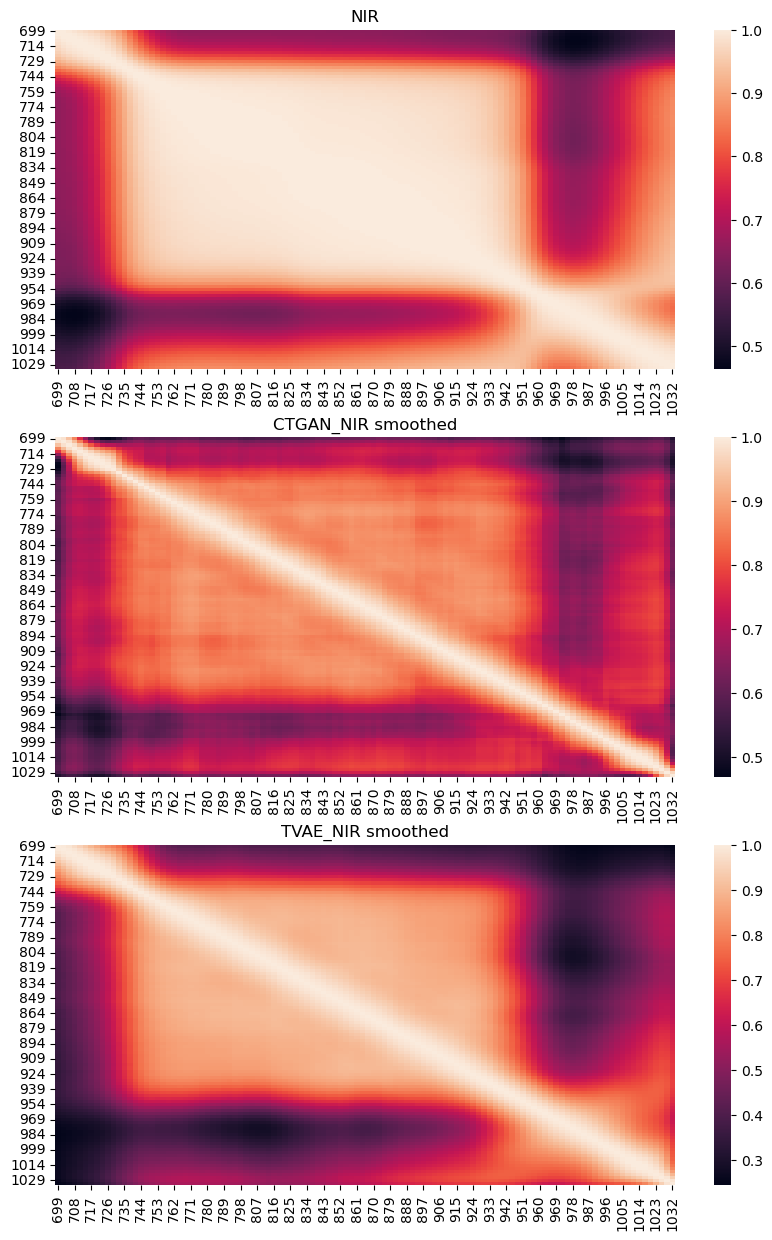

In [325]:
heatmap_specs([nir.corr(), ctgan_nir.corr(), tvae_nir.corr()], ["NIR", "CTGAN_NIR smoothed", "TVAE_NIR smoothed"])

In [326]:
nir_stats = calculate_univariate_stats(nir)  #nir.describe()
ctgan_stats = calculate_univariate_stats(ctgan_nir) #ctgan_nir.describe()
tvae_stats = calculate_univariate_stats(tvae_nir) #tvae_nir.describe()
cos_scores_ctgan = []
cos_scores_tvae = []
for idx in range(nir_stats.shape[0]-1):
    cos_scores_ctgan.append(cosine_similarity(nir_stats.iloc[idx+1, :], ctgan_stats.iloc[idx+1, :]))
    cos_scores_tvae.append(cosine_similarity(nir_stats.iloc[idx+1, :], tvae_stats.iloc[idx+1, :]))

In [327]:
basic_stats_raw = pd.DataFrame(index=nir_stats.index[1:])
basic_stats_raw["CTGAN_NIR"] = cos_scores_ctgan
basic_stats_raw["TVAE_NIR"] = cos_scores_tvae


In [328]:
basic_stats_raw

,CTGAN_NIR,TVAE_NIR
std,0.988951,0.997532
min,0.999627,0.999894
25%,0.999030,0.999965
50%,0.999517,0.999968
75%,0.999628,0.999968
max,0.997640,0.998441
skew,0.965886,0.926937
kurtosis,0.896441,0.900416


In [329]:
corr_diff_tvae = nir.corr()-tvae_nir.corr()
corr_diff_tvae = corr_diff_tvae.abs()
rows, cols = np.triu_indices_from(corr_diff_tvae, k=1)    
unique_corr_tvae = np.array([corr_diff_tvae.iloc[row, col] for row, col in zip(rows, cols)])

In [330]:
corr_diff_ctgan = nir.corr()-ctgan_nir.corr()
corr_diff_ctgan = corr_diff_ctgan.abs()
rows, cols = np.triu_indices_from(corr_diff_ctgan, k=1) 
unique_corr_ctgan = np.array([corr_diff_ctgan.iloc[row, col] for row, col in zip(rows, cols)])

In [331]:
ctgan_corr = ctgan_nir.corr()
rows, cols = np.triu_indices_from(ctgan_corr, k=1)
corr_ctgan = np.array([ctgan_corr.iloc[row, col] for row, col in zip(rows, cols)])

In [332]:
tvae_corr = tvae_nir.corr()
rows, cols = np.triu_indices_from(tvae_corr, k=1)
corr_tvae = np.array([tvae_corr.iloc[row, col] for row, col in zip(rows, cols)])

In [333]:
nir_corr = nir.corr()
rows, cols = np.triu_indices_from(nir_corr, k=1)
corr_nir = np.array([nir_corr.iloc[row, col] for row, col in zip(rows, cols)])

In [334]:
cos_tvae = cosine_similarity(corr_nir, corr_tvae)
cos_ctgan = cosine_similarity(corr_nir, corr_ctgan)

In [335]:
spec_corr = pd.DataFrame(columns=["CTGAN_NIR", "TVAE_NIR"], index=["Mean", "Min", "Max", "Cos sim"])
spec_corr["CTGAN_NIR"] = [np.mean(unique_corr_ctgan), np.min(unique_corr_ctgan), np.max(unique_corr_ctgan), cos_ctgan]
spec_corr["TVAE_NIR"] = [np.mean(unique_corr_tvae), np.min(unique_corr_tvae), np.max(unique_corr_tvae), cos_tvae]


In [336]:
spec_corr

,CTGAN_NIR,TVAE_NIR
Mean,0.079860,0.174313
Min,0.000083,0.000038
Max,0.471514,0.349565
Cos sim,0.997282,0.988119


### Kolmogorov-Smirnov test

In [337]:
from scipy.stats import kstest, ttest_ind, mannwhitneyu

# list for storing kstest scores
kstest_scores_ctgan = []
kstest_scores_tvae = []

# list for storing t-test scores
ttest_scores_ctgan = []
ttest_scores_tvae = []

# list for storing U mann whitney scores
mwu_scores_ctgan = []
mwu_scores_tvae = []

for col in nir.columns:

    # t-test
    ttest_scores_ctgan.append(ttest_ind(nir.loc[:, col], ctgan_nir.loc[:, col])[1])
    ttest_scores_tvae.append(ttest_ind(nir.loc[:, col], tvae_nir.loc[:, col])[1])

    # Mann Whitney U-test
    mwu_scores_ctgan.append(mannwhitneyu(nir.loc[:, col], ctgan_nir.loc[:, col])[1])
    mwu_scores_tvae.append(mannwhitneyu(nir.loc[:, col], tvae_nir.loc[:, col])[1])

    # kolmogorov-smirnov
    kstest_scores_ctgan.append(kstest(nir.loc[:, col], ctgan_nir.loc[:,col])[1])
    kstest_scores_tvae.append(kstest(nir.loc[:, col], tvae_nir.loc[:,col])[1])
    

In [338]:
kstest_mean_ctgan = np.round(np.mean(kstest_scores_ctgan),3)
kstest_mean_tvae = np.round(np.mean(kstest_scores_tvae),3)

ttest_mean_ctgan = np.round(np.mean(ttest_scores_ctgan),3)
ttest_mean_tvae = np.round(np.mean(ttest_scores_tvae),3)

mwu_mean_ctgan = np.round(np.mean(mwu_scores_ctgan), 3)
mwu_mean_tvae = np.round(np.mean(mwu_scores_tvae), 3)

uni_tests = pd.DataFrame(columns=["CTGAN_NIR", "TVAE_NIR"], index=["Kolmogorov-Smirnov", "Student T", "Mann Whitney U"])
uni_tests["CTGAN_NIR"] = [kstest_mean_ctgan, ttest_mean_ctgan, mwu_mean_ctgan]
uni_tests["TVAE_NIR"] = [kstest_mean_tvae, ttest_mean_tvae, mwu_mean_tvae]



In [339]:
uni_tests

,CTGAN_NIR,TVAE_NIR
Kolmogorov-Smirnov,0.000,0.000
Student T,0.020,0.141
Mann Whitney U,0.009,0.128


In [340]:
# CTGAN
mwu_perc_ctgan = np.round(sum(p>0.05 for p in mwu_scores_ctgan)/len(mwu_scores_ctgan)*100, 3)
kstest_perc_ctgan = np.round(sum(p>0.05 for p in kstest_scores_ctgan)/len(mwu_scores_ctgan)*100, 3)
ttest_perc_ctgan = np.round(sum(p>0.05 for p in ttest_scores_ctgan)/len(mwu_scores_ctgan)*100, 3)

# TVAE
mwu_perc_tvae = np.round(sum(p>0.05 for p in mwu_scores_tvae)/len(mwu_scores_ctgan)*100, 3)
kstest_perc_tvae = np.round(sum(p>0.05 for p in kstest_scores_tvae)/len(mwu_scores_ctgan)*100, 3)
ttest_perc_tvae = np.round(sum(p>0.05 for p in ttest_scores_tvae)/len(mwu_scores_ctgan)*100, 3)

uni_tests_perc = pd.DataFrame(columns=["CTGAN_NIR", "TVAE_NIR"], index=["Kolmogorov-Smirnov", "Student T", "Mann Whitney U"])
uni_tests_perc["CTGAN_NIR"] = [kstest_perc_ctgan, ttest_perc_ctgan, mwu_perc_ctgan]
uni_tests_perc["TVAE_NIR"] = [kstest_perc_tvae, ttest_perc_tvae, mwu_perc_tvae]


In [341]:
uni_tests_perc

,CTGAN_NIR,TVAE_NIR
Kolmogorov-Smirnov,0.000,0.000
Student T,6.250,35.714
Mann Whitney U,4.464,29.464


In [342]:
ctgan_tests_df = pd.DataFrame(columns=["Student T", "Mann Whitney U", "Kolmogorov-Smirnov"], index=nir.columns)
tvae_tests_df = pd.DataFrame(columns=["Student T", "Mann Whitney U", "Kolmogorov-Smirnov"], index=nir.columns)

ctgan_tests_df.loc[:,"Student T"] = ttest_scores_ctgan
ctgan_tests_df.loc[:,"Mann Whitney U"] = mwu_scores_ctgan
ctgan_tests_df.loc[:,"Kolmogorov-Smirnov"] = kstest_scores_ctgan

tvae_tests_df.loc[:, "Student T"] = ttest_scores_tvae
tvae_tests_df.loc[:, "Mann Whitney U"] = mwu_scores_tvae
tvae_tests_df.loc[:, "Kolmogorov-Smirnov"] = kstest_scores_tvae

# Reset the index to create a 'Wavelength' column
ctgan_tests_df = ctgan_tests_df.reset_index().rename(columns={'index': 'Wavelength'})
tvae_tests_df = tvae_tests_df.reset_index().rename(columns={'index': 'Wavelength'})

# Convert the 'Wavelength' column to integers
ctgan_tests_df['Wavelength'] = ctgan_tests_df['Wavelength'].astype(int)
tvae_tests_df['Wavelength'] = tvae_tests_df['Wavelength'].astype(int)



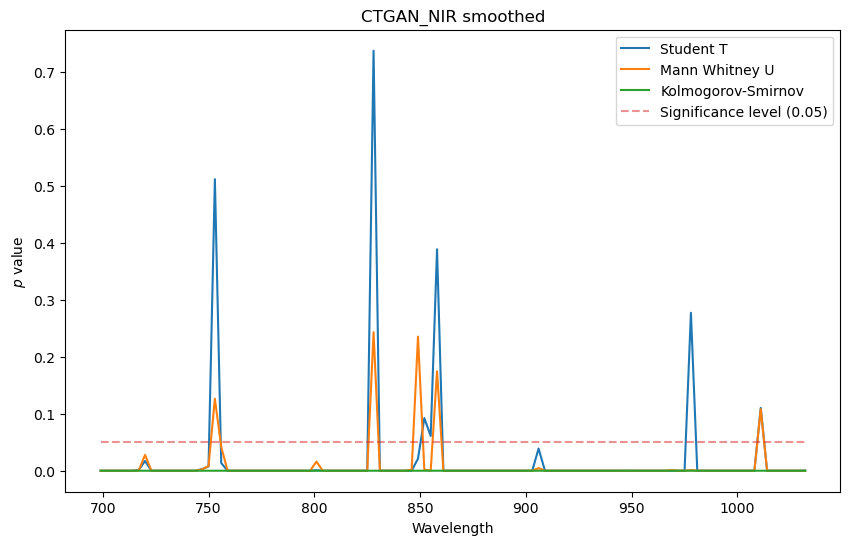

In [343]:
# Plot ctgan_nir using Seaborn lineplots
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='Wavelength', y='Student T', data=ctgan_tests_df, label='Student T')
sns.lineplot(x='Wavelength', y='Mann Whitney U', data=ctgan_tests_df, label='Mann Whitney U')
sns.lineplot(x='Wavelength', y='Kolmogorov-Smirnov', data=ctgan_tests_df, label='Kolmogorov-Smirnov')
sns.lineplot(x='Wavelength', y=0.05, data=ctgan_tests_df, label='Significance level (0.05)', linestyle='--', alpha=0.5)

#plt.axhline(y=0.05, color='red', linestyle='--')
plt.ylabel("$\it{p}$ value")
plt.title("CTGAN_NIR smoothed")
plt.legend()
plt.show()

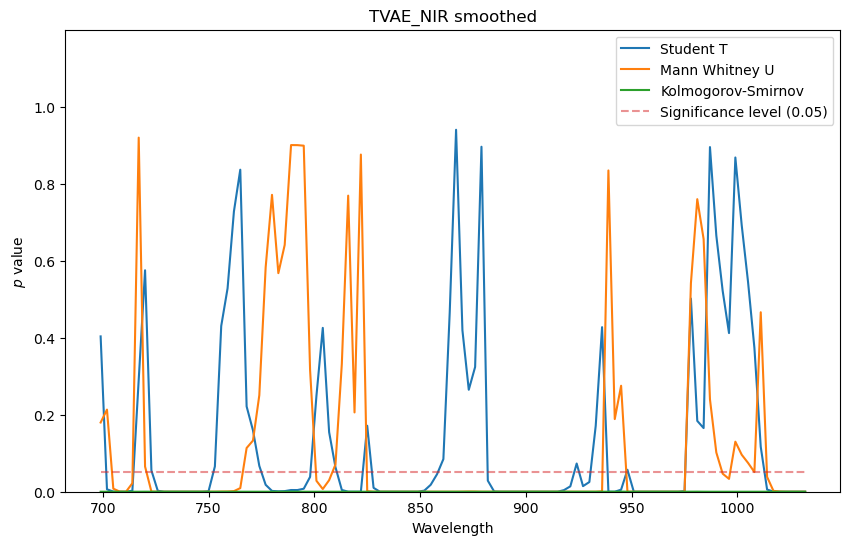

In [344]:
# Plot tvae_nir using Seaborn lineplots
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='Wavelength', y='Student T', data=tvae_tests_df, label='Student T')
sns.lineplot(x='Wavelength', y='Mann Whitney U', data=tvae_tests_df, label='Mann Whitney U')
sns.lineplot(x='Wavelength', y='Kolmogorov-Smirnov', data=tvae_tests_df, label='Kolmogorov-Smirnov')
sns.lineplot(x='Wavelength', y=0.05, data=tvae_tests_df, label='Significance level (0.05)', linestyle='--', alpha=0.5)


#plt.axhline(y=0.05, color='red', linestyle='--')
plt.ylim((0, 1.2))
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylabel("$\it{p}$ value")
plt.title("TVAE_NIR smoothed")
plt.legend()
plt.show()

In [345]:
uni_tests

,CTGAN_NIR,TVAE_NIR
Kolmogorov-Smirnov,0.000,0.000
Student T,0.020,0.141
Mann Whitney U,0.009,0.128


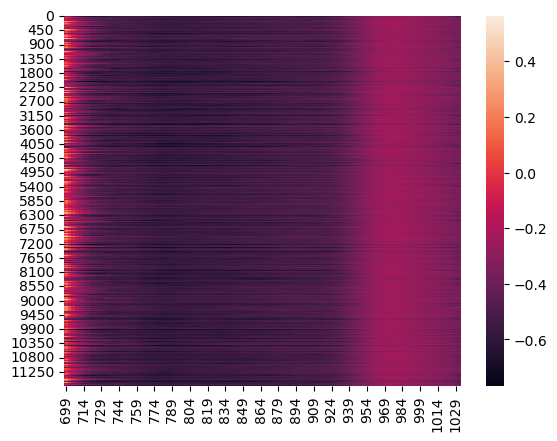

In [346]:
sns.heatmap(ctgan_nir)
plt.show()

In [347]:
nir_response_corr = nir_response.corr()["DM"][:-1]
ctgan_response_corr = ctgan_nir_response.corr()["DM"][:-1]
tvae_response_corr = tvae_nir_response.corr()["DM"][:-1]

In [348]:
nir_response_corr.min()

-0.23581823082331002

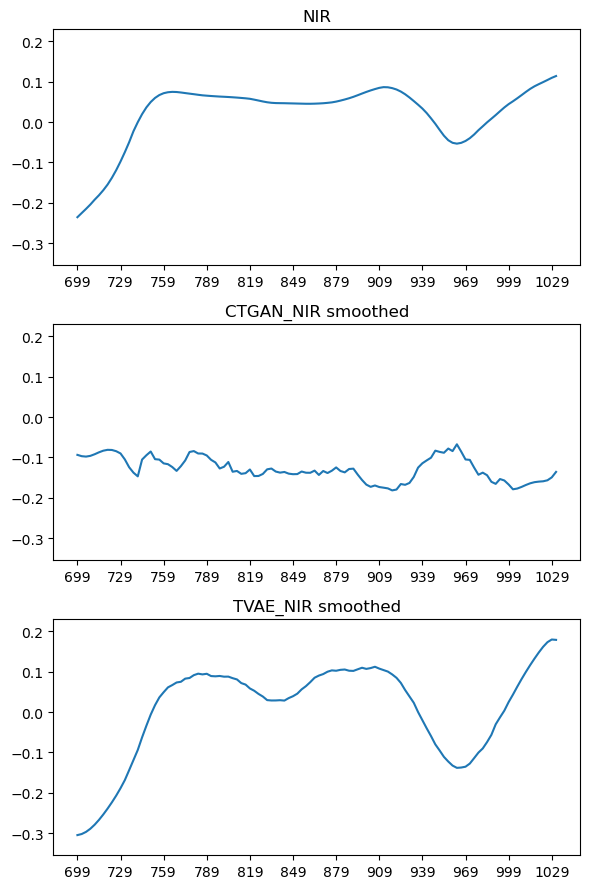

In [349]:
fig, ax = plt.subplots(3,1, figsize=(6,9))

y_min, y_max = min(nir_response_corr.min(), ctgan_response_corr.min(), tvae_response_corr.min())-0.05, max(nir_response_corr.max(), ctgan_response_corr.max(), tvae_response_corr.max())+0.05
#y_min, y_max = min(nir_response_corr[:, 1].min(), ctgan_response_corr[:, 1].min(), tvae_response_corr[:, 1].min())-3, max(nir_response_corr[:, 1].max(), ctgan_response_corr[:, 1].max(), tvae_response_corr[:, 1].max())+3

ax[0].plot(nir_response.corr()["DM"][:-1])
ax[0].set_xticks(nir_response.columns[::10])
ax[0].set_ylim(y_min, y_max)
ax[0].set_title("NIR")

ax[1].plot(ctgan_nir_response.corr()["DM"][:-1])
ax[1].set_xticks(nir_response.columns[::10])
ax[1].set_ylim(y_min, y_max)
ax[1].set_title("CTGAN_NIR smoothed")

ax[2].plot(tvae_nir_response.corr()["DM"][:-1])
ax[2].set_xticks(nir_response.columns[::10])
ax[2].set_ylim(y_min, y_max)
ax[2].set_title("TVAE_NIR smoothed")

plt.tight_layout()
plt.show()

In [350]:
cos_sim_ctgan = np.round(cosine_similarity(nir_response.corr()["DM"][:-1], ctgan_nir_response.corr()["DM"][:-1]), 3)
cos_sim_tvae = np.round(cosine_similarity(nir_response.corr()["DM"][:-1], tvae_nir_response.corr()["DM"][:-1]), 3)

In [351]:
# Creating dataframe that contains results
cos_sim_corr_target = pd.DataFrame([[cos_sim_ctgan, cos_sim_tvae]], columns=["CTGAN_NIR", "TVAE_NIR"], index=["Cos sim"])

In [352]:
cos_sim_corr_target

,CTGAN_NIR,TVAE_NIR
Cos sim,-0.401,0.936


In [353]:
# normalizing data before PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
nir_sc = pd.DataFrame(scaler.fit_transform(nir), columns=nir.columns)
ctgan_sc = pd.DataFrame(scaler.fit_transform(ctgan_nir), columns=ctgan_nir.columns)
tvae_sc = pd.DataFrame(scaler.fit_transform(tvae_nir), columns=tvae_nir.columns)

# Principal Component Analysis
pca = PCA(n_components=0.95)
pca_nir = pca.fit_transform(nir_sc)
pca_nir_variance = pca.explained_variance_
pca_nir_variance_ratio = pca.explained_variance_ratio_
nir_comp = pca.components_
pca_ctgan = pca.fit_transform(ctgan_sc)
pca_ctgan_variance = pca.explained_variance_
pca_ctgan_variance_ratio = pca.explained_variance_ratio_
ctgan_comp = pca.components_
pca_tvae = pca.fit_transform(tvae_sc)
pca_tvae_variance = pca.explained_variance_
pca_tvae_variance_ratio = pca.explained_variance_ratio_
tvae_comp = pca.components_

print(pca_nir.shape)
print(pca_ctgan.shape)
print(pca_tvae.shape)

(11691, 3)
(11691, 10)
(11691, 6)


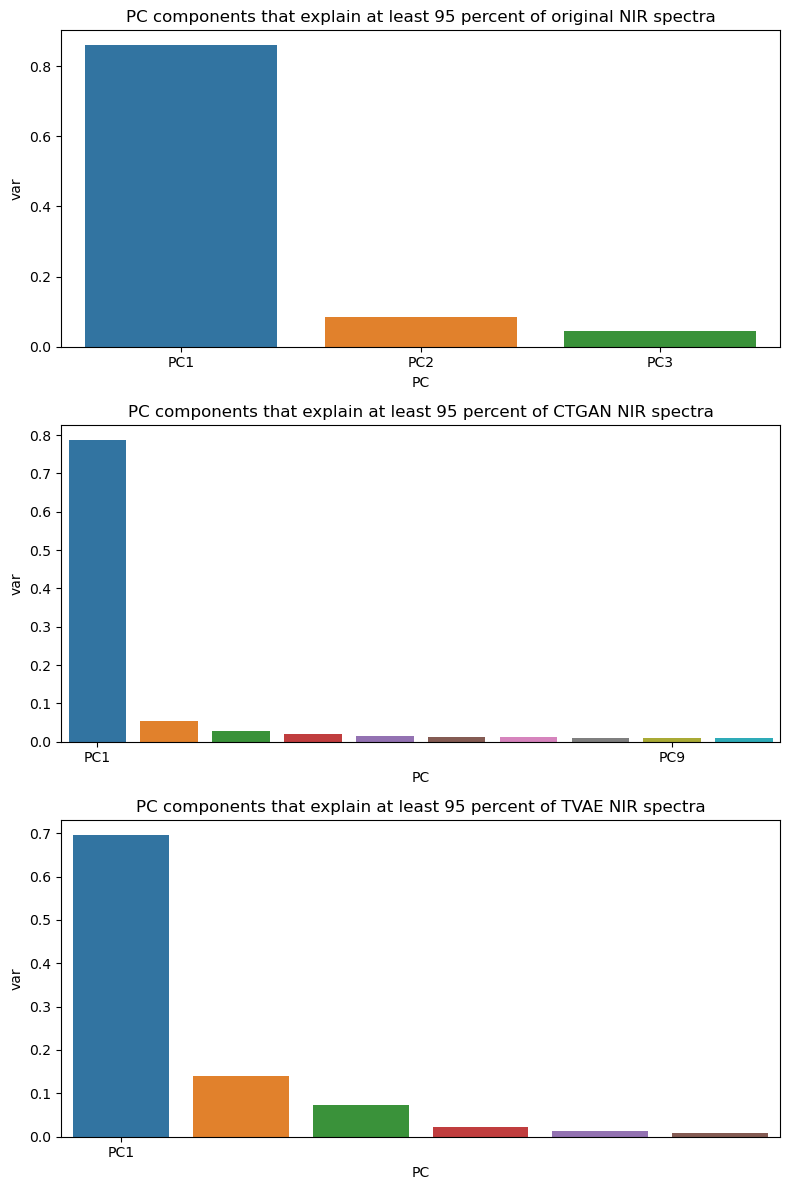

In [354]:
# Scree plots
# Creating dataframes in preparation for scree plots
nirScree = pd.DataFrame({'var':pca_nir_variance_ratio, 'PC':[f"PC{i+1}" for i, _ in enumerate(pca_nir_variance_ratio)]})
ctganScree = pd.DataFrame({'var':pca_ctgan_variance_ratio, 'PC':[f"PC{i+1}" for i, _ in enumerate(pca_ctgan_variance_ratio)]})
tvaeScree = pd.DataFrame({'var':pca_tvae_variance_ratio, 'PC':[f"PC{i+1}" for i, _ in enumerate(pca_tvae_variance_ratio)]})

# Plotting scree plots
fig, ax = plt.subplots(3, 1, figsize=(8,12))

sns.barplot(x='PC', y='var', data=nirScree, ax=ax[0]).set_title('PC components that explain at least 95 percent of original NIR spectra')
sns.barplot(x='PC', y='var', data=ctganScree, ax=ax[1]).set_title('PC components that explain at least 95 percent of CTGAN NIR spectra')
ax[1].set_xticks(ctganScree['PC'].index.tolist()[::8])
sns.barplot(x='PC', y='var', data=tvaeScree, ax=ax[2]).set_title('PC components that explain at least 95 percent of TVAE NIR spectra')
ax[2].set_xticks(tvaeScree['PC'].index.tolist()[::8])

plt.tight_layout()
plt.show()

In [355]:
def plot_scatter(data1, data2, data3, title, subtitle1, subtitle2, subtitle3):
    fig, ax = plt.subplots(2,2, figsize=(12, 8))
    ax[0, 0].scatter(data1[:, 0], data1[:, 1])
    ax[0, 0].set_title(subtitle1)
    ax[0, 1].scatter(data2[:, 0], data2[:, 1])
    ax[0, 1].set_title(subtitle2)
    ax[1, 0].scatter(data1[:, 0], data1[:, 1])
    ax[1, 0].set_title(subtitle1)
    ax[1, 1].scatter(data3[:, 0], data3[:, 1])
    ax[1, 1].set_title(subtitle3)
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

In [356]:
def plot_scatter_pca(data1, data2, data3, title, subtitle1, subtitle2, subtitle3):
    fig, ax = plt.subplots(2,2, figsize=(12, 8))
    
    x_min, x_max = min(data1[:, 0].min(), data2[:, 0].min(), data3[:, 0].min())-3, max(data1[:, 0].max(), data2[:, 0].max(), data3[:, 0].max())+3
    y_min, y_max = min(data1[:, 1].min(), data2[:, 1].min(), data3[:, 1].min())-3, max(data1[:, 1].max(), data2[:, 1].max(), data3[:, 1].max())+3
    
    ax[0, 0].scatter(data1[:, 0], data1[:, 1])
    ax[0, 0].set_title(subtitle1)
    ax[0, 0].set_xlim(x_min, x_max)
    ax[0, 0].set_ylim(y_min, y_max)
    ax[0, 0].set_xlabel("PC1")
    ax[0, 0].set_ylabel("PC2")
    
    ax[0, 1].scatter(data2[:, 0], data2[:, 1])
    ax[0, 1].set_title(subtitle2)
    ax[0, 1].set_xlim(x_min, x_max)
    ax[0, 1].set_ylim(y_min, y_max)
    ax[0, 1].set_xlabel("PC1")
    ax[0, 1].set_ylabel("PC2")
    
    ax[1, 0].scatter(data1[:, 0], data1[:, 1])
    ax[1, 0].set_title(subtitle1)
    ax[1, 0].set_xlim(x_min, x_max)
    ax[1, 0].set_ylim(y_min, y_max)
    ax[1, 0].set_xlabel("PC1")
    ax[1, 0].set_ylabel("PC2")

    ax[1, 1].scatter(data3[:, 0], data3[:, 1])
    ax[1, 1].set_title(subtitle3)
    ax[1, 1].set_xlim(x_min, x_max)
    ax[1, 1].set_ylim(y_min, y_max)
    ax[1, 1].set_xlabel("PC1")
    ax[1, 1].set_ylabel("PC2")
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


In [357]:
def plot_scatter_iso(data1, data2, data3, title, subtitle1, subtitle2, subtitle3):
    fig, ax = plt.subplots(2,2, figsize=(12, 8))
    
    x_min, x_max = min(data1[:, 0].min(), data2[:, 0].min(), data3[:, 0].min())-3, max(data1[:, 0].max(), data2[:, 0].max(), data3[:, 0].max())+3
    y_min, y_max = min(data1[:, 1].min(), data2[:, 1].min(), data3[:, 1].min())-3, max(data1[:, 1].max(), data2[:, 1].max(), data3[:, 1].max())+3
    
    ax[0, 0].scatter(data1[:, 0], data1[:, 1])
    ax[0, 0].set_title(subtitle1)
    ax[0, 0].set_xlim(x_min, x_max)
    ax[0, 0].set_ylim(y_min, y_max)
    ax[0, 0].set_xlabel("LDE1")
    ax[0, 0].set_ylabel("LDE2")
    
    ax[0, 1].scatter(data2[:, 0], data2[:, 1])
    ax[0, 1].set_title(subtitle2)
    ax[0, 1].set_xlim(x_min, x_max)
    ax[0, 1].set_ylim(y_min, y_max)
    ax[0, 1].set_xlabel("LDE1")
    ax[0, 1].set_ylabel("LDE2")
    
    ax[1, 0].scatter(data1[:, 0], data1[:, 1])
    ax[1, 0].set_title(subtitle1)
    ax[1, 0].set_xlim(x_min, x_max)
    ax[1, 0].set_ylim(y_min, y_max)
    ax[1, 0].set_xlabel("LDE1")
    ax[1, 0].set_ylabel("LDE2")

    ax[1, 1].scatter(data3[:, 0], data3[:, 1])
    ax[1, 1].set_title(subtitle3)
    ax[1, 1].set_xlim(x_min, x_max)
    ax[1, 1].set_ylim(y_min, y_max)
    ax[1, 1].set_xlabel("LDE1")
    ax[1, 1].set_ylabel("LDE2")
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


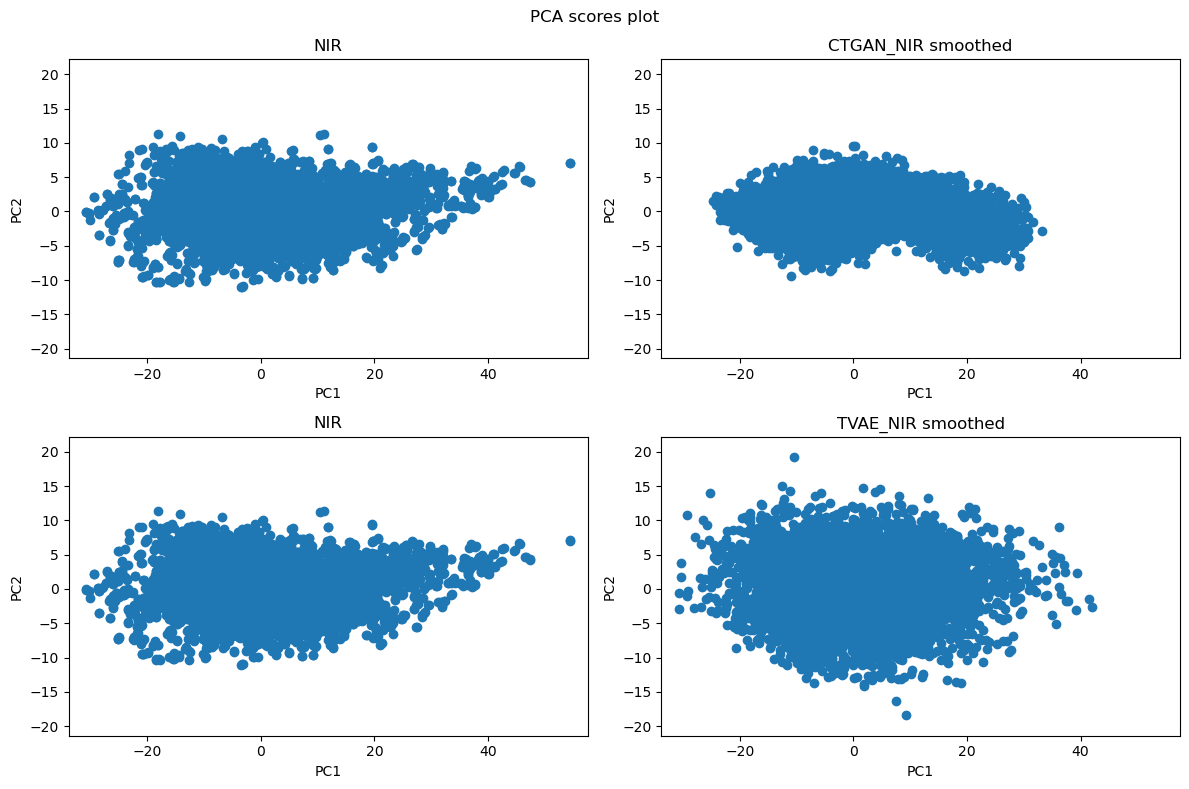

In [358]:
plot_scatter_pca(pca_nir, pca_ctgan, pca_tvae, "PCA scores plot", subtitle1="NIR", subtitle2="CTGAN_NIR smoothed", subtitle3="TVAE_NIR smoothed")

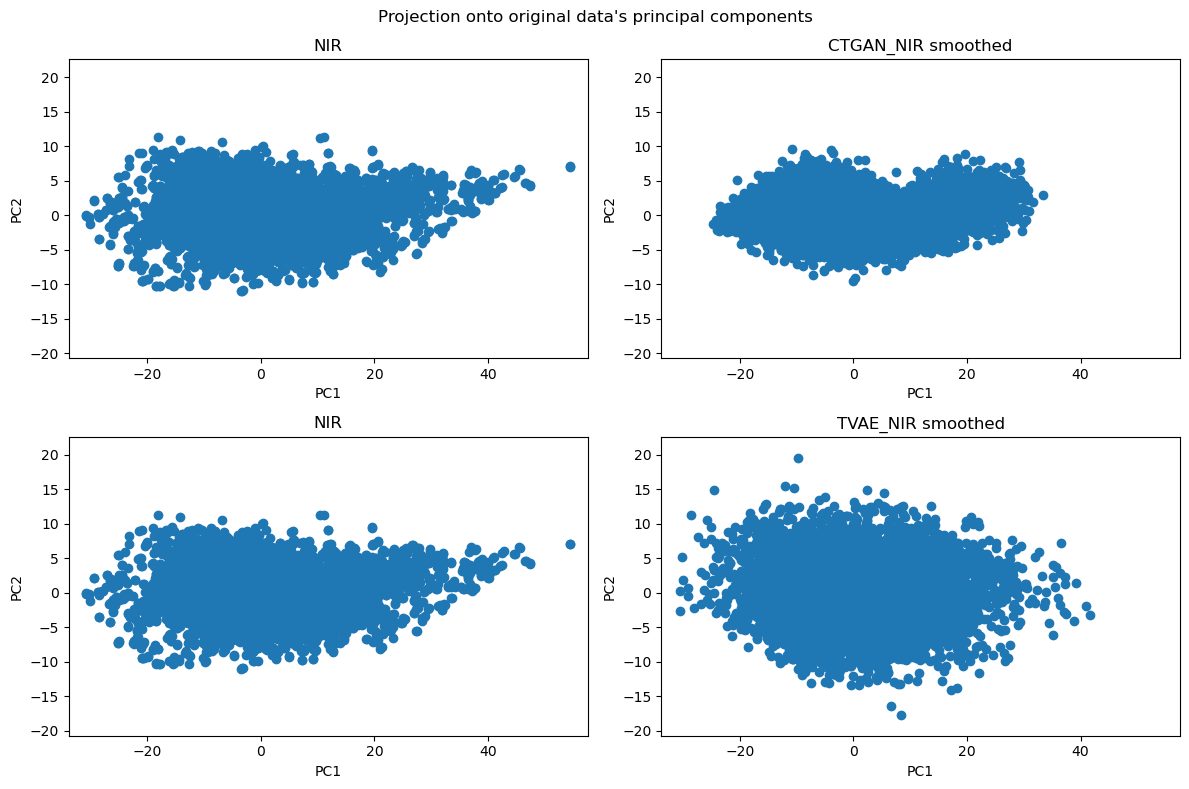

In [359]:
pca = PCA(n_components=2)
pca_nir = pca.fit_transform(nir_sc)
pca_ctgan_nir = pca.transform(ctgan_sc)
pca_tvae_nir = pca.transform(tvae_sc)

plot_scatter_pca(pca_nir, pca_ctgan_nir, pca_tvae_nir, "Projection onto original data's principal components", subtitle1="NIR", subtitle2="CTGAN_NIR smoothed", subtitle3="TVAE_NIR smoothed")

In [360]:
from sklearn.manifold import Isomap
isomap_nir = Isomap(n_components=2).fit_transform(nir_sc)
isomap_ctgan = Isomap(n_components=2).fit_transform(ctgan_sc)
isomap_tvae = Isomap(n_components=2).fit_transform(tvae_sc)

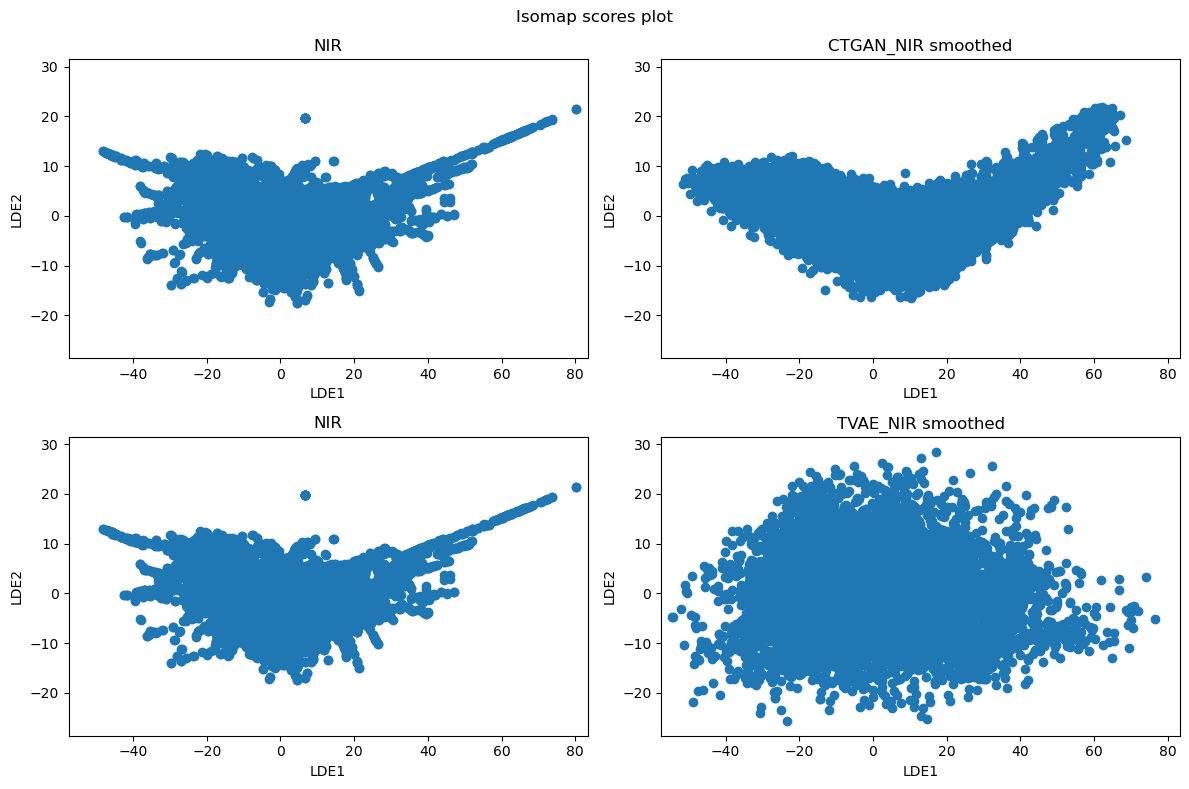

In [361]:
plot_scatter_iso(isomap_nir, isomap_ctgan, isomap_tvae, "Isomap scores plot", subtitle1="NIR", subtitle2="CTGAN_NIR smoothed", subtitle3="TVAE_NIR smoothed")

In [362]:
isomap = Isomap(n_components=2)
isomap.fit_transform(nir)
isomap_ctgan_nir = isomap.transform(ctgan_sc)
isomap_tvae_nir = isomap.transform(tvae_sc)

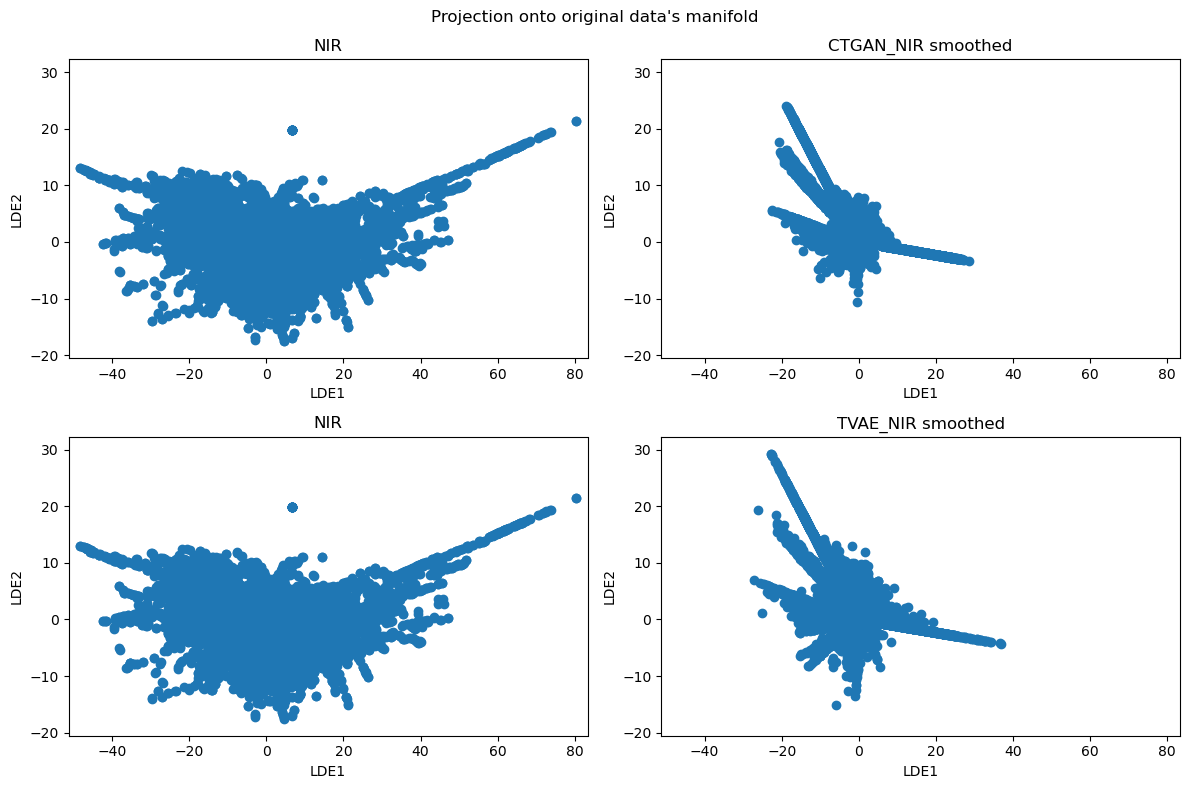

In [363]:
plot_scatter_iso(isomap_nir, isomap_ctgan_nir, isomap_tvae_nir, "Projection onto original data's manifold", subtitle1="NIR", subtitle2="CTGAN_NIR smoothed", subtitle3="TVAE_NIR smoothed")


## Data Labeling Analysis

In [364]:
# creating copies of data
nir_label = nir.copy()
ctgan_label = ctgan_nir.copy()
tvae_label = tvae_nir.copy()

# labeling data
nir_label['label'] = 0
ctgan_label['label'] = 1
tvae_label['label'] = 1

# Concatenating the dataframes
ctgan_label = pd.concat([nir_label, ctgan_label])
tvae_label = pd.concat([nir_label, tvae_label])

# Resetting index of data
ctgan_label.reset_index(inplace=True)
tvae_label.reset_index(inplace=True)

# Permuting the rows
ctgan_label = ctgan_label.reindex(np.random.RandomState(seed=1).permutation(ctgan_label.index))
tvae_label = tvae_label.reindex(np.random.RandomState(seed=1).permutation(tvae_label.index))

# Separating labels from data
X_ctgan = ctgan_label
y_ctgan = X_ctgan.pop('label')

X_tvae = tvae_label
y_tvae = X_tvae.pop('label')

# Splitting the X and y into train and test sets
X_train_ctgan, X_test_ctgan, y_train_ctgan, y_test_ctgan = train_test_split(X_ctgan, y_ctgan, test_size=0.1, stratify=y_ctgan, random_state=1)

X_train_tvae, X_test_tvae, y_train_tvae, y_test_tvae = train_test_split(X_tvae, y_tvae, test_size=0.1, stratify=y_tvae, random_state=1)

# Scaling data
sc_ctgan = StandardScaler()
sc_tvae = StandardScaler()

# Scaling CTGAN
X_train_ctgan_sc = sc_ctgan.fit_transform(X_train_ctgan)
X_test_ctgan_sc = sc_ctgan.transform(X_test_ctgan)

# Scaling TVAE
X_train_tvae_sc = sc_tvae.fit_transform(X_train_tvae)
X_test_tvae_sc = sc_tvae.transform(X_test_tvae)

### Random Forest

In [365]:
forest_ctgan = RandomForestClassifier(n_estimators=100, random_state=9, n_jobs=-1)
forest_ctgan.fit(X_train_ctgan_sc, y_train_ctgan)
forest_ctgan_pred = forest_ctgan.predict(X_test_ctgan_sc)

In [366]:
forest_tvae = RandomForestClassifier(n_estimators=100, random_state=9, n_jobs=-1)
forest_tvae.fit(X_train_tvae_sc, y_train_tvae)
forest_tvae_pred = forest_tvae.predict(X_test_tvae_sc)

### KNN

In [367]:
from sklearn.neighbors import KNeighborsClassifier
KNN_ctgan = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
KNN_ctgan.fit(X_train_ctgan_sc, y_train_ctgan)
KNN_ctgan_pred = KNN_ctgan.predict(X_test_ctgan_sc)

In [368]:
KNN_tvae = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
KNN_tvae.fit(X_train_tvae_sc, y_train_tvae)
KNN_tvae_pred = KNN_tvae.predict(X_test_tvae_sc)

### Decision Tree

In [369]:
from sklearn.tree import DecisionTreeClassifier
tree_ctgan = DecisionTreeClassifier(random_state=9)
tree_ctgan.fit(X_train_ctgan_sc, y_train_ctgan)
tree_ctgan_pred = tree_ctgan.predict(X_test_ctgan_sc)

In [370]:
tree_tvae = DecisionTreeClassifier(random_state=9)
tree_tvae.fit(X_train_tvae_sc, y_train_tvae)
tree_tvae_pred = tree_tvae.predict(X_test_tvae_sc)

### SVM

In [371]:
from sklearn.svm import SVC 
svc_ctgan = SVC(C=100, max_iter=300, kernel='linear', probability=True, random_state=9)
svc_ctgan.fit(X_train_ctgan_sc,y_train_ctgan)
svc_ctgan_pred = svc_ctgan.predict(X_test_ctgan_sc)

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


In [372]:
svc_tvae = SVC(C=100, max_iter=300, kernel='linear', probability=True, random_state=9)
svc_tvae.fit(X_train_tvae_sc,y_train_tvae)
svc_tvae_pred = svc_tvae.predict(X_test_tvae_sc)

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


### MLP

In [373]:
from sklearn.neural_network import MLPClassifier

# Instantiate the MLPClassifier with the given parameters
mlp_ctgan = MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                    max_iter=300,
                    random_state=9)

mlp_ctgan.fit(X_train_ctgan_sc, y_train_ctgan)
mlp_ctgan_pred = mlp_ctgan.predict(X_test_ctgan_sc)

In [374]:
mlp_tvae = MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                    max_iter=300,
                    random_state=9)

mlp_tvae.fit(X_train_tvae_sc, y_train_tvae)
mlp_tvae_pred = mlp_tvae.predict(X_test_tvae_sc)

In [375]:
# CTGAN
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

ctgan_scores = pd.DataFrame(columns=["Accuracy", "F1", "Precision","Recall"],index=["RF", "KNN", "DT", "SVM", "MLP"])
ctgan_scores.loc["RF", :] = [accuracy_score(forest_ctgan_pred, y_test_ctgan), f1_score(forest_ctgan_pred, y_test_ctgan), precision_score(forest_ctgan_pred, y_test_ctgan), recall_score(forest_ctgan_pred, y_test_ctgan)]
ctgan_scores.loc["KNN", :] = [accuracy_score(KNN_ctgan_pred, y_test_ctgan), f1_score(KNN_ctgan_pred, y_test_ctgan), precision_score(KNN_ctgan_pred, y_test_ctgan), recall_score(KNN_ctgan_pred, y_test_ctgan)]
ctgan_scores.loc["DT", :] = [accuracy_score(tree_ctgan_pred, y_test_ctgan), f1_score(tree_ctgan_pred, y_test_ctgan), precision_score(tree_ctgan_pred, y_test_ctgan), recall_score(tree_ctgan_pred, y_test_ctgan)]
ctgan_scores.loc["SVM", :] = [accuracy_score(svc_ctgan_pred, y_test_ctgan), f1_score(svc_ctgan_pred, y_test_ctgan), precision_score(svc_ctgan_pred, y_test_ctgan), recall_score(svc_ctgan_pred, y_test_ctgan)]
ctgan_scores.loc["MLP", :] = [accuracy_score(mlp_ctgan_pred, y_test_ctgan), f1_score(mlp_ctgan_pred, y_test_ctgan), precision_score(mlp_ctgan_pred, y_test_ctgan), recall_score(mlp_ctgan_pred, y_test_ctgan)]



In [376]:
ctgan_scores

,Accuracy,F1,Precision,Recall
RF,0.998717,0.998716,0.997436,1.0
KNN,0.886704,0.872289,0.773504,1.0
DT,0.990167,0.990133,0.986325,0.993971
SVM,0.992304,0.992353,0.998291,0.986486
MLP,1.0,1.0,1.0,1.0


In [377]:
# TVAE

tvae_scores = pd.DataFrame(columns=["Accuracy", "F1", "Precision","Recall"],index=["RF", "KNN", "DT", "SVM", "MLP"])
tvae_scores.loc["RF", :] = [accuracy_score(forest_tvae_pred, y_test_tvae), f1_score(forest_tvae_pred, y_test_tvae), precision_score(forest_tvae_pred, y_test_tvae), recall_score(forest_tvae_pred, y_test_tvae)]
tvae_scores.loc["KNN", :] = [accuracy_score(KNN_tvae_pred, y_test_tvae), f1_score(KNN_tvae_pred, y_test_tvae), precision_score(KNN_tvae_pred, y_test_tvae), recall_score(KNN_tvae_pred, y_test_tvae)]
tvae_scores.loc["DT", :] = [accuracy_score(tree_tvae_pred, y_test_tvae), f1_score(tree_tvae_pred, y_test_tvae), precision_score(tree_tvae_pred, y_test_tvae), recall_score(tree_tvae_pred, y_test_tvae)]
tvae_scores.loc["SVM", :] = [accuracy_score(svc_tvae_pred, y_test_tvae), f1_score(svc_tvae_pred, y_test_tvae), precision_score(svc_tvae_pred, y_test_tvae), recall_score(svc_tvae_pred, y_test_tvae)]
tvae_scores.loc["MLP", :] = [accuracy_score(mlp_tvae_pred, y_test_tvae), f1_score(mlp_tvae_pred, y_test_tvae), precision_score(mlp_tvae_pred, y_test_tvae), recall_score(mlp_tvae_pred, y_test_tvae)]

In [378]:
tvae_scores

,Accuracy,F1,Precision,Recall
RF,0.988884,0.988851,0.98547,0.992255
KNN,0.683198,0.538318,0.369231,0.993103
DT,0.952116,0.951431,0.937607,0.965669
SVM,0.910646,0.915419,0.966667,0.869331
MLP,0.999572,0.999572,0.999145,1.0


## Utility

In [379]:
# Setting up datasets with response variable "DM"
nir_spec_train, nir_spec_test, nir_dm_train, nir_dm_test = train_test_split(nir, nir_dm, test_size=0.2, random_state=9)
tvae_spec_train, tvae_spec_test, tvae_dm_train, tvae_dm_test = train_test_split(tvae_nir, tvae_dm, test_size=0.2, random_state=9)
ctgan_spec_train, ctgan_spec_test, ctgan_dm_train, ctgan_dm_test = train_test_split(ctgan_nir, ctgan_dm, test_size=0.2, random_state=9)

# Scaling data
sc_nir = StandardScaler()
sc_ctgan = StandardScaler()
sc_tvae = StandardScaler()

nir_spec_train_sc = sc_nir.fit_transform(nir_spec_train)
nir_spec_test_sc = sc_nir.transform(nir_spec_test)

ctgan_spec_train_sc = sc_ctgan.fit_transform(ctgan_spec_train)
ctgan_spec_test_sc = sc_ctgan.transform(nir_spec_test)

tvae_spec_train_sc = sc_tvae.fit_transform(tvae_spec_train)
tvae_spec_test_sc = sc_tvae.transform(nir_spec_test)

In [380]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
def train_and_predict(rd, rd_y, sd, sd_y):

    rd_train, rd_test, rd_train_y, rd_test_y = train_test_split(rd, rd_y, test_size=0.2, random_state=9)
    sd_train, sd_test, sd_train_y, sd_test_y = train_test_split(sd, sd_y, test_size=0.2, random_state=9)

    rd_sc = StandardScaler()
    sd_sc = StandardScaler()

    rd_train_sc = rd_sc.fit_transform(rd_train)
    rd_test_sc = rd_sc.transform(rd_test)

    sd_train_sc = sd_sc.fit_transform(sd_train)
    sd_test_sc = sd_sc.transform(rd_test)

    results = {"Real":[], "Synthetic":[]}

    models = {"RF":RandomForestRegressor(n_estimators=100, random_state=9, n_jobs=-1), 
    "KNN":KNeighborsRegressor(n_neighbors=10, n_jobs=-1),
    "DT":DecisionTreeRegressor(random_state=9),
    "SVM":SVR(C=100, max_iter = 300, kernel = "linear"),
    "MLP":MLPRegressor(hidden_layer_sizes=(128, 64, 32), max_iter=300, random_state=9)}

    for name, model in models.items():
        model.fit(rd_train_sc, rd_train_y)
        results["Real"].append(model.score(rd_test_sc, rd_test_y))
        model.fit(sd_train_sc, sd_train_y)
        results["Synthetic"].append(model.score(sd_test_sc, rd_test_y))

    return results


In [381]:
results_ctgan = train_and_predict(nir, nir_dm, ctgan_nir, ctgan_dm)

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.


In [382]:
utility_ctgan = pd.DataFrame(results_ctgan, index=["RF", "KNN", "DT", "SVM", "MLP"])
utility_ctgan

,Real,Synthetic
RF,0.667707,-0.209106
KNN,0.372196,-0.294911
DT,0.292846,-2.450614
SVM,-8.574527,-14.083039
MLP,0.708510,-1.452801


In [383]:
results_tvae = train_and_predict(nir, nir_dm, tvae_nir, tvae_dm)

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


In [384]:
utility_tvae = pd.DataFrame(results_tvae, index=["RF", "KNN", "DT", "SVM", "MLP"])
utility_tvae

,Real,Synthetic
RF,0.667707,0.189407
KNN,0.372196,0.150815
DT,0.292846,-0.388260
SVM,-8.574527,-2.277547
MLP,0.708510,-0.041049


In [385]:
import shap
forest_tvae_shap = RandomForestRegressor()

X_train, X_test, y_train, y_test = train_test_split(tvae_nir, tvae_dm, test_size=0.2, random_state=9)

forest_tvae_shap.fit(X_train, y_train)
explainer = shap.Explainer(forest_tvae_shap.predict, X_test)
shap_values = explainer.shap_values(X_test)


AttributeError: module 'warnings' has no attribute 'DeprecationWarning'

In [ ]:
explainer(X_test)

Permutation explainer: 2340it [11:14,  3.43it/s]                          


.values =
array([[ 0.40567869,  0.06904393,  0.02573377, ...,  0.08328804,
         0.15983023,  0.33907665],
       [-0.34214836, -0.09300554, -0.05150344, ...,  0.03154062,
         0.04360907, -0.09606411],
       [-0.04313805,  0.04738455,  0.01273139, ..., -0.06379321,
        -0.09933328, -0.66460894],
       ...,
       [ 0.7997033 ,  0.1638449 ,  0.0402751 , ...,  0.00616146,
        -0.05367229, -0.03312258],
       [-0.60236425, -0.11831435, -0.05489052, ..., -0.00802827,
         0.0236046 , -0.00107075],
       [ 0.5645624 ,  0.21694651,  0.07671502, ..., -0.10255351,
        -0.1017563 , -0.16535144]])

.base_values =
array([16.53903322, 16.53903322, 16.53903322, ..., 16.53903322,
       16.53903322, 16.53903322])

.data =
array([[-0.55704027, -0.55374573, -0.55045118, ..., -0.3393941 ,
        -0.3468413 , -0.3542885 ],
       [ 0.00716335, -0.04036913, -0.08790162, ..., -0.35731167,
        -0.36795883, -0.37860598],
       [-0.20400205, -0.24541775, -0.28683345, ..., -0

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:

{'importances_mean': array([ 1.92019341e-02, -2.83572081e-02, -1.46122330e-02, -1.31780576e-02,
        -1.02533184e-02, -1.56834721e-02, -1.48552227e-02, -2.96005014e-03,
        -5.46451425e-03, -7.23213651e-03, -4.52193941e-03, -1.78267840e-03,
        -3.04218460e-03, -5.05386438e-03, -6.12222441e-04, -5.77394432e-03,
        -4.31123362e-03, -2.62898046e-03,  1.23640267e-03,  1.09410439e-03,
         3.96944483e-04, -1.15901990e-03, -2.15600796e-03,  1.30971300e-03,
         1.43686500e-03,  3.03459595e-03,  1.28460040e-03,  2.11728372e-03,
         8.60543716e-03,  1.01193853e-03,  1.58308511e-03, -9.62138688e-04,
        -2.27940701e-03,  1.05092467e-03, -2.35090515e-03,  1.14034079e-03,
         6.85098925e-05, -1.22394508e-03, -8.68258418e-04, -3.55075999e-04,
        -5.61541096e-03, -3.46520274e-04,  7.69233175e-04,  1.10373993e-03,
        -3.79206710e-03, -2.40789340e-03, -2.57046075e-04, -4.82182788e-03,
        -1.53168441e-03, -3.70747023e-04, -4.55229786e-03, -3.377806